In [1]:
import numpy as np
import h5py 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib

In [2]:
di = h5py.File("data_z_126.59.hdf5","r")
dci = np.array(di['dc_fdm'])
fdci = np.array(di['f2_dc_fdm'])
pi = np.array(di['potential'])
amp2i = np.array(di['psi_amp2'])
dci = np.reshape(dci,(128,128,128))

In [30]:
di = h5py.File("data_z_127.00.hdf5","r")
dci = np.array(di['dc_fdm'])
pi = np.array(di['potential'])
amp2i = np.array(di['psi_amp2'])

d = h5py.File("data_z_91.49.hdf5","r")
dc = np.array(d['dc_fdm'])
p = np.array(d['potential'])
amp2 = np.array(d['psi_amp2'])

d2 = h5py.File("data_z_-0.00.hdf5","r")
dc2 = np.array(d2['dc_fdm'])
p2 = np.array(d2['potential'])
amp22 = np.array(d2['psi_amp2'])

dc = np.reshape(dc,(128,128,128))
dc2 = np.reshape(dc2,(128,128,128))
dci = np.reshape(dci,(128,128,128))

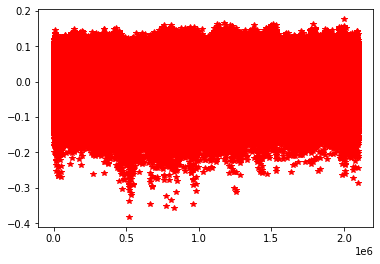

In [31]:
plt.plot(pi.flatten(),"r*")
#plt.plot(p2.flatten(),"b*")

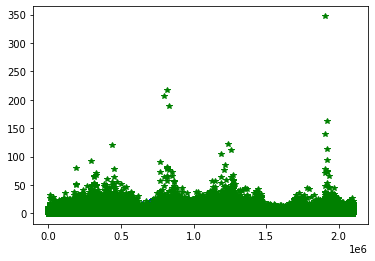

In [32]:
plt.plot(dci.flatten(),"r*")
plt.plot(dc.flatten(),"b*")
plt.plot(dc2.flatten(),"g*")

In [33]:
print(dci.max(),dc.max(),dc2.max())
print(dc2.flatten().sum())

0.7649282038873713 35.398073903306724 347.13375164206457
-493564.8558635638


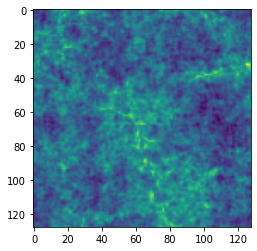

In [3]:
ap = 30
plt.imshow(dci[:,ap,:])

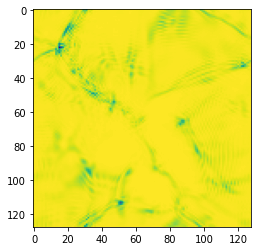

In [61]:
ap = 30
plt.imshow(p2[:,ap,:])

In [36]:
x = np.linspace(0.0,1.0,128)
y = np.linspace(0.0,1.0,128)
xr = np.linspace(0.0,1.0,512)
yr = np.linspace(0.0,1.0,512)
xx,yy = np.meshgrid(x,y,indexing="ij")
xxr,yyr = np.meshgrid(xr,yr,indexing="ij")
c = np.stack((xx,yy),axis=2)
c = np.reshape(c,(-1,2))
#cx = c[:,:,0].flatten()
#cy = c[:,:,0].flatten()
print(c.shape,xx.shape,yy.shape)

(16384, 2) (128, 128) (128, 128)


/home/manvendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


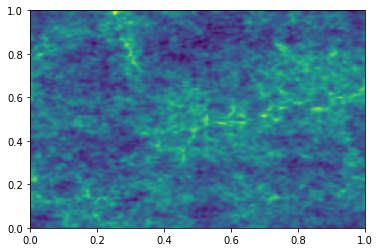

In [37]:
z = griddata(c,dci[:,ap,:].flatten(),(xxr,yyr),method='cubic')
plt.pcolormesh(xxr,yyr,z)

/home/manvendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


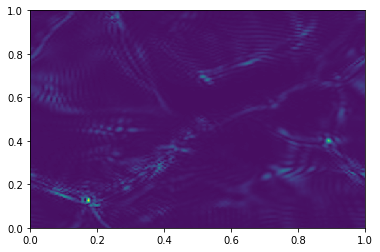

In [38]:
z = griddata(c,dc2[:,ap,:].flatten(),(xxr,yyr),method='cubic')
plt.pcolormesh(xxr,yyr,z)

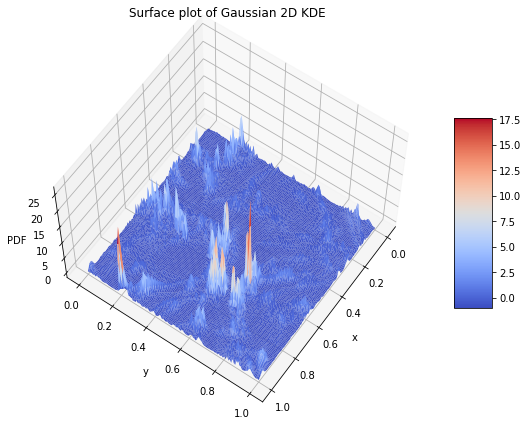

In [39]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, dc2[:,ap+20,:], rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

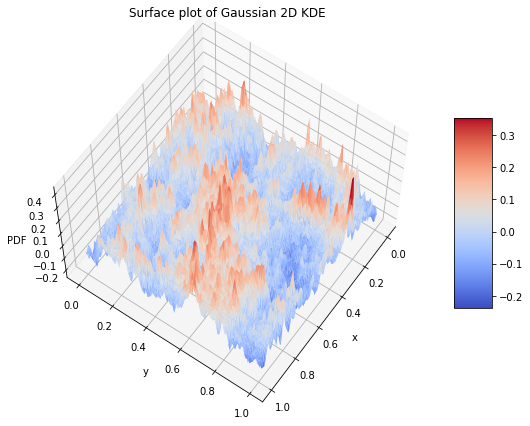

In [40]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, dci[:,ap,:], rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

In [4]:
def k_int(k_grid,n=128,dk=0.01):
    lst=[]
    kmag = np.sqrt(np.sum(np.square(k_grid),axis=-1))
    
    tN = k_grid.shape[0]
    print(tN)
    for i in range(tN):
        
        k_int_val =  np.floor((kmag[i]/dk))
        lst.append(k_int_val)
    
    nbins = int((kmag.max()-kmag.min())/dk) +1 
    print(nbins)
    return np.array(lst),nbins
    

In [5]:
fini = h5py.File("ini_grid.hdf5","r")

In [6]:
k_grid = np.array(fini['k_grid'])
x_grid = np.array(fini['x_grid'])
kmag = np.sqrt(np.sum(np.square(k_grid),axis=-1))

print((kmag.max()-kmag.min()))
k_grid.shape


11.085125168440817


(2097152, 3)

In [7]:
def cal_power_spec(dc,k_int,fdc_t=False,fdc=None,n=128,n_bins=10,dk=0.01):
    pwr = np.zeros((n_bins+1,))
    pwr_cnt = np.ones((n_bins+1,))
    kmag = np.zeros((n_bins+1,))
    #print(n,n_bins)
  
    if not fdc_t:
        cdc = np.zeros_like(dc)
        dc_c = dc+(1j*cdc)
        f_dc = np.fft.fftn(dc_c)
        f_dc2 = np.square(np.absolute(f_dc))
    for i in range(n_bins):
        pwr[i] = 0.0
        #print(i)
        
    for i in range(n):
        for k in range(n):
            for l in range(n):
                ci = (n*n)*i + n*k + l
                kint = int(k_int[ci])
                if not fdc_t:
                    pwr[kint] = pwr[kint] + f_dc2[i,k,l]
                else:
                    pwr[kint] = pwr[kint] + fdc[ci]
                pwr_cnt[kint] = pwr_cnt[kint] + 1
    
    for i in range(n_bins):
        if(pwr_cnt[i]>1):
            pwr[i] = pwr[i]/(pwr_cnt[i]-1.0)
        else:
            pwr[i] = pwr[i]/(pwr_cnt[i])
        kmag[i] = dk*(i+1.0)
        
    return pwr,kmag
    

In [8]:
k_intg,nb  = k_int(k_grid,dk=0.02)

2097152
555


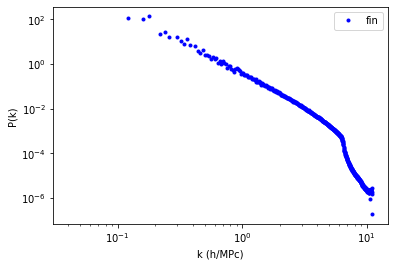

In [9]:
psi,ki = cal_power_spec(dci,k_intg,fdc_t=True,fdc=fdci,n_bins=nb+1,dk=0.02)

plt.yscale('log')
plt.xscale('log')
plt.xlabel("k (h/MPc)")
plt.ylabel("P(k)")
#plt.plot(ki[1:],psi[1:],"r.",label="ini")
plt.plot(ki[1:],psi[1:],"b.",label="fin")
#plt.plot(ps2[1:],'b.',label="f")

plt.legend(loc='best')



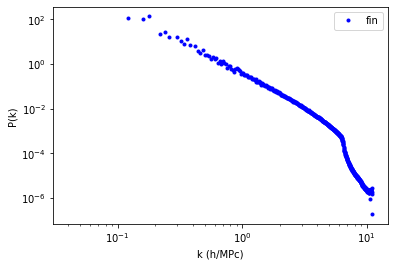

In [12]:
psi,ki = cal_power_spec(dci,k_intg,fdc_t=False,n_bins=nb+1,dk=0.02)

plt.yscale('log')
plt.xscale('log')
plt.xlabel("k (h/MPc)")
plt.ylabel("P(k)")
#plt.plot(ki[1:],psi[1:],"r.",label="ini")
plt.plot(ki[1:],psi[1:]/(128.0*128.0*128.0),"b.",label="fin")
#plt.plot(ps2[1:],'b.',label="f")

plt.legend(loc='best')
#ps2,k2 = cal_power_spec(p2,k_intg,n_bins=nb+1,dk=1.0)

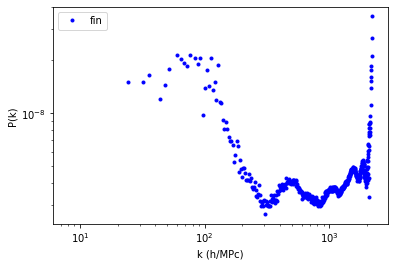

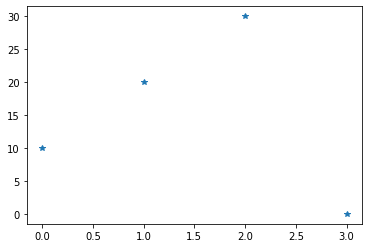

In [89]:
plt.plot(ki,"*")

In [58]:
kmag = np.sqrt(np.sum(np.square(k_grid),axis=-1))

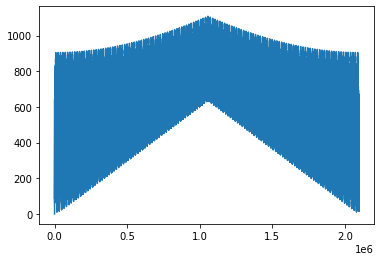

In [60]:
plt.plot(kmag)

In [72]:
np.sqrt(3.0*(128.0/20.0)*(128.0/20.0))

11.085125168440817

In [76]:
xmag = np.sqrt(np.sum(np.square(x_grid),axis=-1))

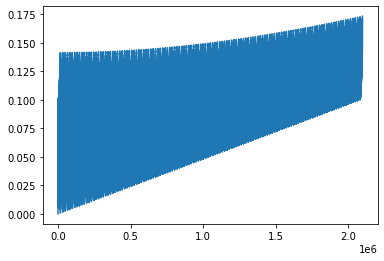

In [77]:
plt.plot(xmag)

In [18]:
dtn = 128.0**3.0
cdc = np.zeros_like(dc)
dc_c = dc+(1j*cdc)
f_dc = np.fft.fftn(dc_c)
r_fdc = np.fft.ifftn(f_dc)
rdc = np.real(r_fdc)

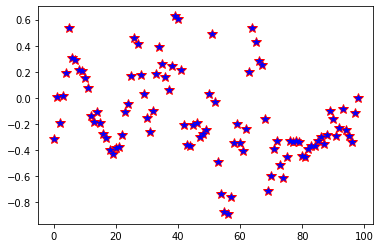

In [26]:
plt.plot(rdc.flatten()[1:100],"r*",ms=10.0)
plt.plot(dc.flatten()[1:100],"b*")